# Finding Embeddings Demo

## Introduction

In this demo, we'll explore word embeddings, which are dense vector representations of words that capture their semantic meanings. We'll start by generating simple co-occurrence-based embeddings and then utilize pre-defined embeddings with our BPE tokenizer. Finally, we'll integrate these embeddings with our n-gram model using approximate nearest neighbors matching to enhance text generation.

## 1. Generating Simple Embeddings

**Objectives:**
- Understand basic methods to generate word embeddings.
- Implement a simple co-occurrence-based embedding.

In [2]:
import numpy as np
from collections import defaultdict
import re
import urllib.request
import os
import zipfile
from sklearn.metrics.pairwise import cosine_similarity

def download_corpus(url, filename):
    """
    Download the corpus from the specified URL and save it to the given filename.
    
    Args:
        url (str): The URL to download the corpus from.
        filename (str): The local filename to save the downloaded corpus.
        
    Returns:
        str: The path to the downloaded corpus file.
    """
    urllib.request.urlretrieve(url, filename)
    print(f"Corpus downloaded successfully and saved to {filename}.")
    return filename

# URL for "Alice's Adventures in Wonderland"
corpus_url = 'https://www.gutenberg.org/files/11/11-0.txt'
filename = 'alice_in_wonderland.txt'

# Download the corpus
if not os.path.exists(filename):
    download_corpus(corpus_url, filename)

# Read the corpus
with open(filename, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f"Corpus length: {len(corpus)} characters")

Corpus length: 163918 characters


In [3]:
def generate_simple_embeddings(tokens, embedding_dim=50, window_size=2):
    """
    Generate simple word embeddings based on co-occurrence within a window.
    
    Args:
        tokens (list): List of tokens from the corpus.
        embedding_dim (int): Dimension of the embedding vectors.
        window_size (int): The size of the context window.
        
    Returns:
        dict: A dictionary mapping each word to its embedding vector.
    """
    # Initialize co-occurrence matrix
    co_occurrence = defaultdict(lambda: defaultdict(int))
    vocabulary = set(tokens)
    
    for index, word in enumerate(tokens):
        for i in range(1, window_size + 1):
            if index + i < len(tokens):
                context_word = tokens[index + i]
                co_occurrence[word][context_word] += 1
            if index - i >= 0:
                context_word = tokens[index - i]
                co_occurrence[word][context_word] += 1
    
    # Initialize embeddings randomly
    embeddings = {word: np.random.rand(embedding_dim) for word in vocabulary}
    
    # Simple update: sum context vectors weighted by co-occurrence frequency
    for word in vocabulary:
        for context_word, freq in co_occurrence[word].items():
            embeddings[word] += freq * embeddings[context_word]
    
    # Normalize embeddings
    for word in embeddings:
        norm = np.linalg.norm(embeddings[word])
        if norm > 0:
            embeddings[word] = embeddings[word] / norm
    
    return embeddings

In [5]:
# Tokenize the corpus using simple whitespace tokenization
tokens = re.findall(r'\b\w+\b', corpus.lower())
print(f"Total tokens: {len(tokens)}")
print("Tokens:", tokens[:10])

Total tokens: 30591
Tokens: ['the', 'project', 'gutenberg', 'ebook', 'of', 'alice', 's', 'adventures', 'in', 'wonderland']


In [6]:
embedding_dim = 50
window_size = 2

# Generate simple embeddings
simple_embeddings = generate_simple_embeddings(tokens, embedding_dim, window_size)
print(f"Generated embeddings for {len(simple_embeddings)} words.")
print("Sample embeddings:")
sample_words = list(simple_embeddings.keys())[:5]
for word in sample_words:
    print(f"{word}: {simple_embeddings[word][:5]}...")  # Display first 5 dimensions

Generated embeddings for 3144 words.
Sample embeddings:
two: [0.13925314 0.1434551  0.1540751  0.15973252 0.15557855]...
won: [0.14112709 0.15772376 0.1024333  0.10957601 0.0833924 ]...
immediately: [0.15639459 0.1703086  0.08464753 0.15757425 0.15900974]...
trying: [0.12632004 0.15426433 0.10309681 0.17229259 0.13676421]...
fancy: [0.10967216 0.17254131 0.14376178 0.1273823  0.14933461]...


In [15]:
# %pip install umap

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import random

def plot_embeddings(embeddings, num_words=100, method='tsne', random_state=42):
    """
    Plot word embeddings using t-SNE or UMAP.
    
    Args:
        embeddings (dict): Mapping of tokens to embedding vectors.
        num_words (int): Number of words to plot.
        method (str): 'tsne' or 'umap'.
        random_state (int): Seed for reproducibility.
    """
    # Select a random subset of words
    if num_words > len(embeddings):
        num_words = len(embeddings)
    sampled_tokens = random.sample(list(embeddings.keys()), num_words)
    sampled_embeddings = np.array([embeddings[token] for token in sampled_tokens])
    
    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=30)
        reduced_embeddings = reducer.fit_transform(sampled_embeddings)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(sampled_embeddings)
    else:
        raise ValueError("Method must be 'tsne' or 'umap'")
    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o', edgecolor='k')
    
    for i, token in enumerate(sampled_tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    
    plt.title(f'Word Embeddings Visualized using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

Plotting embeddings with t-SNE...


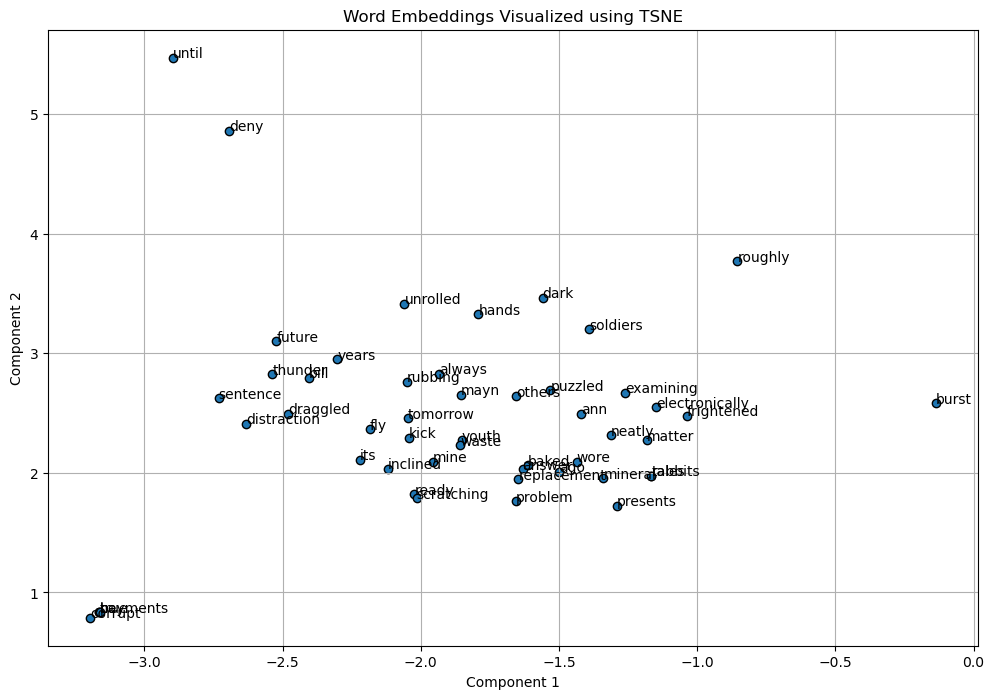

In [19]:
print("Plotting embeddings with t-SNE...")
plot_embeddings(simple_embeddings, num_words=50, method='tsne')

In [21]:

# Plot using UMAP
print("Plotting embeddings with UMAP...")
plot_embeddings(simple_embeddings, num_words=20, method='umap')
# END SOLUTION


Plotting embeddings with UMAP...


AttributeError: module 'umap' has no attribute 'UMAP'

## 2. Using Pre-Defined Embeddings and Tokenizer

**Objectives:**
- Load pre-trained word embeddings (GloVe).
- Map tokens to their corresponding embedding vectors using the BPE tokenizer.
- Explore semantic similarities using these embeddings.

In [7]:
def load_pretrained_embeddings(glove_path, embedding_dim=50):
    """
    Load pre-trained GloVe embeddings from a file.
    
    Args:
        glove_path (str): Path to the GloVe embeddings file.
        embedding_dim (int): Dimension of the embedding vectors.
        
    Returns:
        dict: A dictionary mapping words to their embedding vectors.
    """
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings[word] = vector
    return embeddings

In [12]:
# Download GloVe embeddings if not already present
glove_dim = 50
glove_filename = f'glove.6B.{glove_dim}d.txt'
glove_zip = 'glove.6B.zip'
glove_url = f'http://nlp.stanford.edu/data/glove.6B.zip'

if not os.path.exists(glove_filename):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip)
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("GloVe embeddings downloaded and extracted.")

GloVe embeddings downloaded and extracted.


In [27]:
# Load GloVe embeddings
pretrained_embeddings = load_pretrained_embeddings(glove_filename, glove_dim)
print(f"Loaded {len(pretrained_embeddings)} pre-trained embeddings.")
print("Sample embeddings:")
sample_words = list(pretrained_embeddings.keys())[:5]
for word in sample_words:
    print(f"{word}: {pretrained_embeddings[word][:5]}...")  # Display first 5 dimensions

Loaded 400000 pre-trained embeddings.
Sample embeddings:
the: [ 0.418    0.24968 -0.41242  0.1217   0.34527]...
,: [ 0.013441  0.23682  -0.16899   0.40951   0.63812 ]...
.: [ 0.15164  0.30177 -0.16763  0.17684  0.31719]...
of: [ 0.70853  0.57088 -0.4716   0.18048  0.54449]...
to: [ 0.68047  -0.039263  0.30186  -0.17792   0.42962 ]...


In [28]:
def map_tokens_to_embeddings(tokens, pretrained_embeddings, embedding_dim=50):
    token_embeddings = {}
    for token in set(tokens):
        if token in pretrained_embeddings:
            token_embeddings[token] = pretrained_embeddings[token]
        else:
            # Initialize random embedding for unknown tokens
            token_embeddings[token] = np.random.rand(embedding_dim)
    return token_embeddings

In [29]:
# Here, we'll reuse the simple tokenization
# Tokenize the corpus using simple whitespace tokenization
tokens = re.findall(r'\b\w+\b', corpus.lower())

# Map tokens to embeddings
token_embeddings = map_tokens_to_embeddings(tokens, pretrained_embeddings, glove_dim)
print(f"Mapped {len(token_embeddings)} tokens to embeddings.")
print("Sample token embeddings:")
sample_tokens = list(token_embeddings.keys())[:5]
for token in sample_tokens:
    print(f"{token}: {token_embeddings[token][:5]}...")  # Display first 5 dimensions

Mapped 3144 tokens to embeddings.
Sample token embeddings:
two: [0.58289 0.36258 0.34065 0.36416 0.34337]...
won: [-1.5561   0.86241  0.14604  1.1389  -0.16875]...
immediately: [ 0.7172  -0.50492  0.21984 -0.30208  0.19903]...
trying: [ 0.44349 -0.7187   0.74168 -0.30663  0.32147]...
fancy: [ 0.23749  -0.013988 -0.88366  -0.26156   0.055294]...


## 3. Integrating Embeddings with N-Grams Using Approximate Nearest Neighbors

**Objectives:**
- Utilize embeddings to perform approximate nearest neighbors matching for n-grams.
- Enhance the n-gram model by considering semantic similarities.

**Demo:**

Instead of relying on exact matches in the n-gram frequency dictionary, we'll use cosine similarity between embeddings to find the nearest matching tokens. This allows the model to generate more semantically coherent text by considering similar words rather than only exact next words.

In [ ]:
def get_nearest_token(current_token, token_embeddings, top_n=1):
    """
    Find the nearest token(s) based on cosine similarity.
    
    Args:
        current_token (str): The current token.
        token_embeddings (dict): Mapping of tokens to embeddings.
        top_n (int): Number of nearest tokens to return.
        
    Returns:
        list: List of nearest tokens.
    """
    if current_token not in token_embeddings:
        return []
    
    current_vector = token_embeddings[current_token].reshape(1, -1)
    similarities = {}
    for token, vector in token_embeddings.items():
        if token == current_token:
            continue
        sim = cosine_similarity(current_vector, vector.reshape(1, -1))[0][0]
        similarities[token] = sim
    
    # Sort tokens by similarity score in descending order
    sorted_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return [token for token, sim in sorted_similar[:top_n]]

def generate_text_with_embeddings(prefix, token_embeddings, beam_width=3, max_length=20):
    """
    Generate text using n-grams with approximate nearest neighbors matching.
    
    Args:
        prefix (str): The starting token.
        token_embeddings (dict): Mapping of tokens to embeddings.
        beam_width (int): Number of sequences to keep at each step.
        max_length (int): Maximum number of tokens to generate.
        
    Returns:
        list: Generated sequence of tokens.
    """
    sequences = [(prefix, 0.0)]  # (sequence, score)
    
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            last_token = seq.split()[-1]
            nearest_tokens = get_nearest_token(last_token, token_embeddings, top_n=beam_width)
            for token in nearest_tokens:
                candidate_seq = seq + ' ' + token
                candidate_score = score - math.log(1.0 / beam_width)  # Simplified scoring
                all_candidates.append((candidate_seq, candidate_score))
        
        # Sort all candidates by score and select top beam_width
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
        
        # Debug: Show current sequences
        print(f"Current sequences (beam_width={beam_width}):")
        for seq, sc in sequences:
            print(f"Sequence: {seq} | Score: {sc}")
        print("-" * 50)
        
        # Stop if no candidates are available
        if not sequences:
            break
    
    # Select the sequence with the lowest score
    best_sequence = min(sequences, key=lambda tup: tup[1])[0]
    return best_sequence

In [ ]:
# BEGIN SOLUTION
# Example seed prefix
seed_prefix = "alice"

# Generate text using embeddings-based n-gram model
generated_sequence = generate_text_with_embeddings(seed_prefix, token_embeddings, beam_width=3, max_length=20)

print("\nGenerated Text with Embeddings-based N-Grams:")
print(generated_sequence)
# END SOLUTION

## 4. Evaluation Exercise

**Objective:**
- Evaluate the impact of different techniques on text generation quality.

**Task:**

1. **N-Gram Evaluation:**
   - Modify the n-gram model to support different values of N (e.g., 2, 3, 4).
   - Generate text using each n-gram model and assess the coherence and diversity of the output.
   - Consider metrics such as perplexity or BLEU scores for quantitative evaluation.

2. **Embedding Matching Evaluation:**
   - Compare text generation using exact n-gram matches versus approximate nearest neighbors matching.
   - Analyze how semantic similarities influence the quality of the generated text.

**Instructions:**

- Implement the necessary modifications to support different n-gram sizes.
- Use the `generate_text_with_embeddings` function with varying beam widths and embedding techniques.
- Document your findings and provide insights into how each technique affects the model's performance.

In [ ]:
# Exercise implementation by the student